# Declining Bee Populations in the United States

##### The goal of this project is to provide an in depth & comprehensive analysis of trends from 2002 to 2017. This involves identifying which regions experienced the most significant population changes, analyzing statistical patterns, and a forecast model to project future colony counts.

## Set Up

*Importing in the necessary libraries.*

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from prophet import Prophet

_Loading in the data_

In [35]:
data_path = "C:/BeePop/"
bee_colonies_filtered = pd.read_csv(data_path + "Bee_Colonies_Filtered.csv")
geo_codes = pd.read_csv(data_path + "Geo_Codes.csv")
population = pd.read_csv(data_path + "Population.csv")

*Standardizing and preparing lookup dictionaries for mapping state/county codes to readable names*

In [36]:
gc = geo_codes.copy()
gc.columns = gc.columns.str.strip().str.lower().str.replace(' ', '_')
gc['key'] = list(zip(gc['state_ansi'], gc['county_ansi']))
county_lookup = dict(zip(gc['key'], gc['area_name']))
state_lookup = gc.drop_duplicates(subset='state_ansi').set_index('state_ansi')['area_name'].to_dict()


_Total Bee Colonies Over Time_

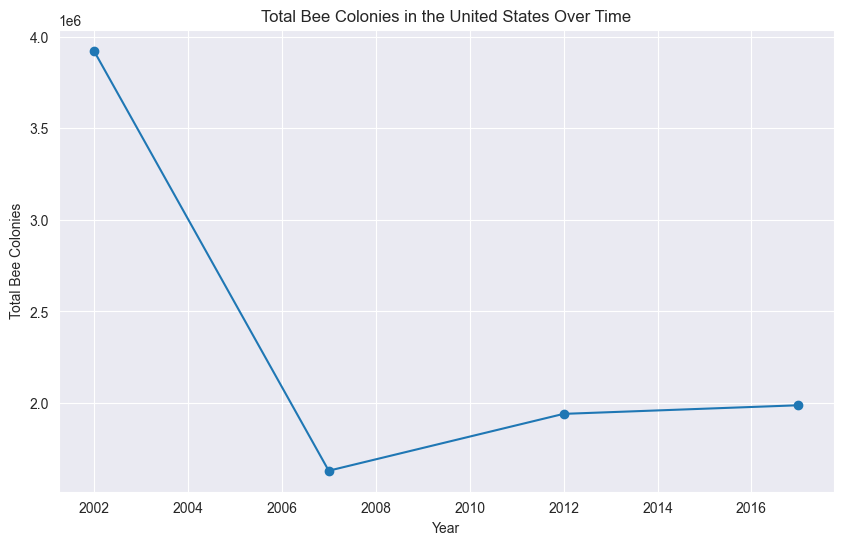

In [37]:
yearly_totals = bee_colonies_filtered.groupby('year')['colonies'].sum()
plt.figure(figsize = (10,6))
plt.plot(yearly_totals.index, yearly_totals.values, marker = 'o')
plt.title('Total Bee Colonies in the United States Over Time')
plt.xlabel('Year')
plt.ylabel('Total Bee Colonies')
plt.show()

_Evaluating the net national change in bee colonies over the 15-year period._

In [38]:
total_by_year = bee_colonies_filtered.groupby('year')['colonies'].sum()
change_total = total_by_year.loc[2017] - total_by_year.loc[2002]
print(f"Net change in total bee colonies from 2002 to 2017: {change_total:,}")

Net change in total bee colonies from 2002 to 2017: -1,936,351


_Identifying states that have experienced the most growth in bee populations._

In [39]:
state_year = bee_colonies_filtered.groupby(['state_ansi','year'])['colonies'].sum().reset_index()
pivot = state_year.pivot(index='state_ansi',columns='year', values='colonies')
pivot['colony_change'] = pivot[2017] - pivot[2002]
top_states = pivot.sort_values('colony_change', ascending=False).head(5)
top_states.index = [state_lookup.get(i, str(i)) for i in top_states.index]
print("\nTop 5 States with the Largest Increase in Colonies From 2002 to 2017:")
print(top_states['colony_change'])


Top 5 States with the Largest Increase in Colonies From 2002 to 2017:
California    52191.0
45             1479.0
Illinois        182.0
21              161.0
32             -211.0
Name: colony_change, dtype: float64


_Identifying counties that contributed the most to colony growth._

In [40]:
county_year = bee_colonies_filtered.groupby(['state_ansi', 'county_ansi', 'year'])['colonies'].sum().reset_index()
pivot = county_year.pivot(index=['state_ansi', 'county_ansi'], columns = 'year', values = 'colonies')
pivot['colony_change'] = pivot[2017] - pivot[2002]
top_counties = pivot.sort_values('colony_change', ascending=False).head(5)
top_counties.index = [county_lookup.get(i, f"{i[0]}-{i[1]}") for i in top_counties.index]
print("\nTop 5 Counties with Largest Increase in Colonies From 2002 to 2017:")
print(top_counties['colony_change'])


Top 5 Counties with Largest Increase in Colonies From 2002 to 2017:
Kern County      132331.0
48-1              62838.0
Butte County      57055.0
Madera County     47759.0
Merced County     42132.0
Name: colony_change, dtype: float64


_Visualizing the spread of bee colonies across all counties in 2017._

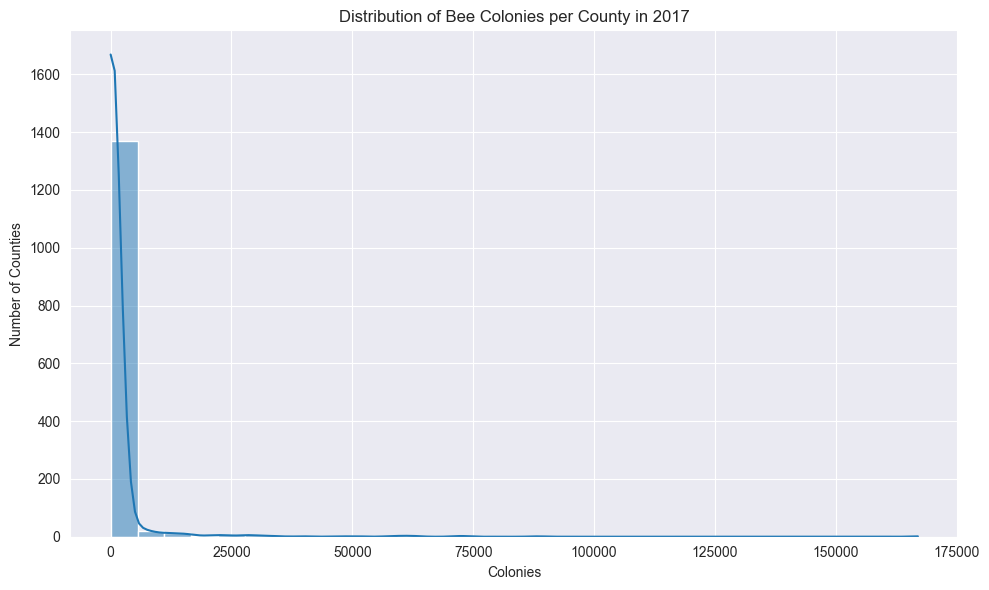

In [41]:
colony_2017 = bee_colonies_filtered[bee_colonies_filtered['year'] == 2017]['colonies']
plt.figure(figsize = (10,6))
sns.histplot(colony_2017, bins=30, kde=True)
plt.title("Distribution of Bee Colonies per County in 2017")
plt.xlabel("Colonies")
plt.ylabel("Number of Counties")
plt.tight_layout()
plt.show()

_Computing basic statistics (mean, std, min, max) for 2017 colonies._

In [42]:
summary_stats = colony_2017.describe()
print("\nStatistical Summary for Bee Colonies per County in 2017:")
print(summary_stats)


Statistical Summary for Bee Colonies per County in 2017:
count      1430.000000
mean       1389.870629
std        7423.820642
min           3.000000
25%          91.000000
50%         191.000000
75%         426.750000
max      166984.000000
Name: colonies, dtype: float64


_Using Shapiro-Wilk test to assess if colony data in 2017 is normally distributed._

In [43]:
stat, p_value = stats.shapiro(colony_2017.sample(n=min(5000, len(colony_2017))))
print("\nShapiro-Wilk Test for Normality (2017 Colonies):")
print(f"Statist = {stat:.4f}, p-value = {p_value:.4f}")
if p_value > 0.05:
    print("Data likely follows a normal distribution")
else:
    print("Data does not follow a normal distribution")


Shapiro-Wilk Test for Normality (2017 Colonies):
Statist = 0.1554, p-value = 0.0000
Data does not follow a normal distribution


_Calculating Pearson correlation to determine overall national trend._

In [44]:
correlation = total_by_year.corr(pd.Series(total_by_year.index, index = total_by_year.index))
print("\nPearson Correlation between Year and Total Colonies:")
print(f"r = {correlation:.4f}")


Pearson Correlation between Year and Total Colonies:
r = -0.6775


_Evaluating how trends vary by state and identifying strongest upward trends._

In [45]:
regional_corrs = {}
for state in bee_colonies_filtered['state_ansi'].unique():
    df = bee_colonies_filtered[bee_colonies_filtered['state_ansi'] == state]
    yearly = df.groupby('year')['colonies'].sum()
    if len(yearly) >= 2:
        r = yearly.corr(pd.Series(yearly.index, index=yearly.index))
        regional_corrs[state_lookup.get(state, str(state))] = r

_Top 5 strongest positive correlations_

In [46]:
print("\nCorrelation Between Year nad Colonies by State:")
top_corr_states = sorted(regional_corrs.items(), key=lambda x: x[1], reverse = True)[:5]
for state, r in top_corr_states:
    print(f"{state}: {r:.4f}")


Correlation Between Year nad Colonies by State:
45: 0.3299
California: 0.2825
32: 0.2532
Illinois: 0.1285
21: 0.1203


_Fitting a linear model to estimate trend direction and strength_

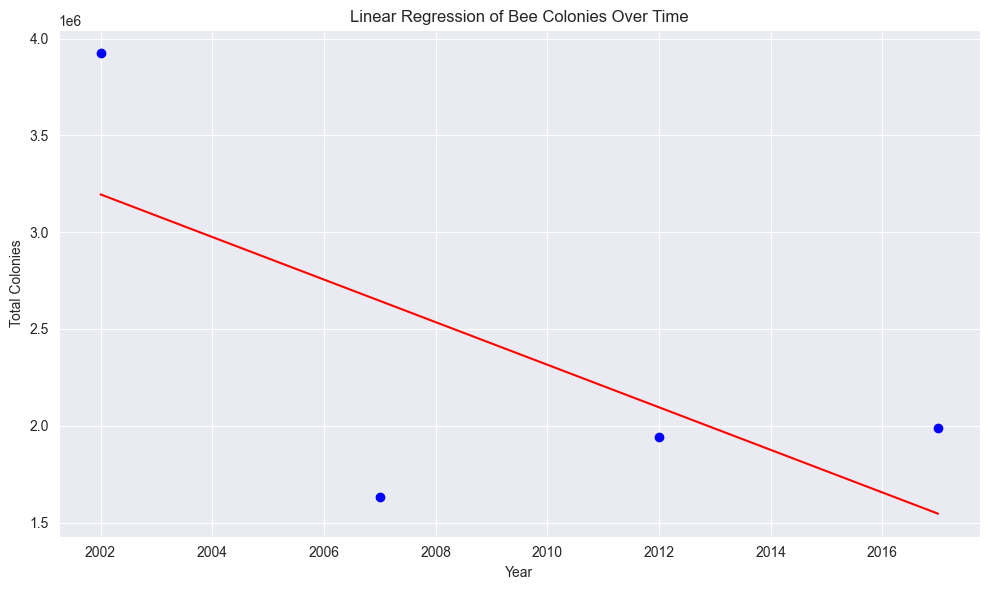


Linear Regression Coefficients:
Slope: -109971.24, Intercept: 223357652.78


In [47]:
x = total_by_year.index.values.reshape(-1, 1)
y = total_by_year.values.reshape(-1, 1)
model = LinearRegression().fit(x, y)
y_pred = model.predict(x)

plt.figure(figsize = (10,6))
plt.scatter(x,y, label='Actual', color='blue')
plt.plot(x, y_pred, color='red', label='Linear Fit')
plt.title("Linear Regression of Bee Colonies Over Time")
plt.xlabel('Year')
plt.ylabel('Total Colonies')
plt.tight_layout()
plt.show()

print("\nLinear Regression Coefficients:")
print(f"Slope: {model.coef_[0][0]:.2f}, Intercept: {model.intercept_[0]:.2f}")

_Using Prophet to model and forecast colony numbers for 5 additional years._

05:12:27 - cmdstanpy - INFO - Chain [1] start processing
05:12:27 - cmdstanpy - INFO - Chain [1] done processing


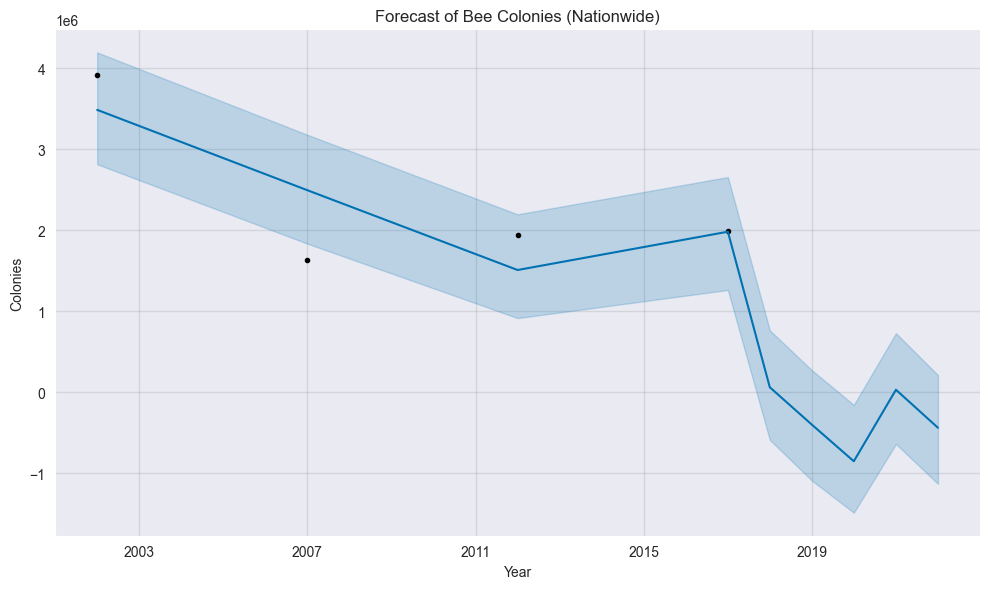

In [51]:
forecast_df = total_by_year.reset_index()
forecast_df.columns = ['ds', 'y']
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'], format='%Y')
model = Prophet(yearly_seasonality=True)
model.fit(forecast_df)
future = model.make_future_dataframe(periods=5, freq='YE')
forecast = model.predict(future)

fig_forecast = model.plot(forecast)
plt.title("Forecast of Bee Colonies (Nationwide)")
plt.xlabel("Year")
plt.ylabel("Colonies")
plt.tight_layout()
plt.show()